In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/MyDrive/Colab_Notebooks/HW4P1/handout/hw4

/content/drive/MyDrive/Colab_Notebooks/HW4P1/handout/hw4


In [26]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import sys
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests_hw4 import test_prediction, test_generation

In [27]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

#num_workers = 8 if cuda else 0

print("Cuda = ", str(cuda),  " system version = ", sys.version)

Cuda =  True  system version =  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [6]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [7]:
# data loader

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.p = np.random.random_sample()

    def __iter__(self):
        # concatenate your articles and build into batches
        if self.shuffle: 
          np.random.shuffle(self.dataset)
        concate_data = np.concatenate(self.dataset)
        #x = torch.LongTensor(concate_data)
        #y = torch.LongTensor(concate_data)
        if self.p > 0.9: 
          seq_len = int(np.random.normal(70/2, 5))
        else: 
          seq_len = int(np.random.normal(70, 5))

        index = 0
        input = []
        target = []
        #equal size
        batch_size = (len(concate_data)//seq_len)*seq_len
        x = torch.LongTensor(concate_data[:batch_size])
        y = torch.LongTensor(concate_data[1:batch_size + 1])
        while index < batch_size:
            new_x = x[index: index+seq_len]
            new_y = y[index: index+seq_len]
            input.append(new_x)
            target.append(new_y)
            index += seq_len
        batch_nums = len(input)//self.batch_size
        input = torch.stack(input, dim = 0)[:batch_nums*self.batch_size].reshape(batch_nums, self.batch_size, -1)
        target = torch.stack(target, dim = 0)[:batch_nums*self.batch_size].reshape(batch_nums, self.batch_size, -1)
        for i in range(len(input)): 
          yield input[i], target[i]

In [8]:
#Class LockedDropout
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

In [9]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size, embedding_dim = 400, hidden_dim = 1150):
        super(LanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.lock_dropout = LockedDropout()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, num_layers= 3,
                           batch_first = True)
        self.fc1 = nn.Linear(self.hidden_dim, vocab_size)


    def forward(self, x, hidden = None):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        embed = self.embedding(x)
        embed = self.lock_dropout(embed, 0.5)
        #batch, seq_len = x.size()
        if hidden is None: 
          out, hidden = self.lstm(embed)
        else: 
          out, hidden = self.lstm(embed, hidden)
        #out, hidden = self.lstm(embed, hidden)
        out = self.lock_dropout(out, 0.5)
        out = self.fc1(out)
        return out,  hidden

    


In [10]:
# model trainer
class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 0.001, weight_decay=1e-5)
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr = 0.001) 拉胯拉胯
        self.criterion = nn.CrossEntropyLoss()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
          inputs = inputs.to(device)
          targets = targets.to(device)
          epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """

        self.optimizer.zero_grad()
        out, hidden = self.model(inputs)
        #reshape targets
        loss = self.criterion(out.view(-1, out.size(2)), targets.flatten())
        loss.backward()
        self.optimizer.step()
        return loss
        
    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [11]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        inp = torch.LongTensor(inp).to(device)
        out = model(inp)[0]
        out = out[:, -1]
        return out.detach().cpu().numpy()

        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """        
        inp = torch.LongTensor(inp).to(device)
        out, hidden = model(inp) 
        seq = []
        word = torch.argmax(out,dim=2)[:,-1].unsqueeze(1)
        seq.append(word.detach().cpu())
        for i in range(forward-1):
          out, hidden = model(word, hidden = hidden) 
          word = torch.argmax(out,dim=2)[:,-1].unsqueeze(1)
          seq.append(word.detach().cpu())
        conct = np.concatenate(seq, axis = 1)
        return conct
                
                

In [12]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 15
BATCH_SIZE = 128


In [13]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1639337648


In [14]:
model = LanguageModel(len(vocab)).cuda()
print(model)
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
#next(iter(loader))
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

LanguageModel(
  (lock_dropout): LockedDropout()
  (embedding): Embedding(33278, 400)
  (lstm): LSTM(400, 1150, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=1150, out_features=33278, bias=True)
)


In [15]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

[TRAIN]  Epoch [2/15]   Loss: 7.2702
[VAL]  Epoch [2/15]   Loss: 5.9244
Saving model, predictions and generated output for epoch 0 with NLL: 5.9243584
[TRAIN]  Epoch [3/15]   Loss: 6.3124
[VAL]  Epoch [3/15]   Loss: 5.3964
Saving model, predictions and generated output for epoch 1 with NLL: 5.3964195
[TRAIN]  Epoch [4/15]   Loss: 5.9973
[VAL]  Epoch [4/15]   Loss: 5.1240
Saving model, predictions and generated output for epoch 2 with NLL: 5.1239886
[TRAIN]  Epoch [5/15]   Loss: 5.7889
[VAL]  Epoch [5/15]   Loss: 4.8909
Saving model, predictions and generated output for epoch 3 with NLL: 4.890851
[TRAIN]  Epoch [6/15]   Loss: 5.6114
[VAL]  Epoch [6/15]   Loss: 4.7722
Saving model, predictions and generated output for epoch 4 with NLL: 4.772194
[TRAIN]  Epoch [7/15]   Loss: 5.5180
[VAL]  Epoch [7/15]   Loss: 4.6296
Saving model, predictions and generated output for epoch 5 with NLL: 4.6295967
[TRAIN]  Epoch [8/15]   Loss: 5.3433
[VAL]  Epoch [8/15]   Loss: 4.4651
Saving model, prediction

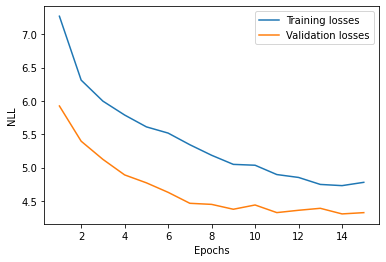

In [16]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [17]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | the most important of the German and Ottoman force .
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = <eol> = = = = = =
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | single , and was certified Gold by the Recording Industry
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | and the <unk> of the <unk> . <eol> = =
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | @-@ out of the ball . <eol> = = =
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | to the Yankees , was the first time he was
Input | Output #6: <unk> , $ 96 million USD ) .

In [28]:
!make runid=1639337648 epoch=15

make: *** No targets specified and no makefile found.  Stop.
